### Ploting buckets after training

In [38]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
from annoy import AnnoyIndex
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import seaborn as sns

from keras.layers import Concatenate, Add, Lambda, merge, Average

%matplotlib inline

In [39]:
from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

In [40]:
MAX_SEQUENCE_LENGTH_T = 20 # 100
MAX_SEQUENCE_LENGTH_D = 20 # 500
EMBEDDING_DIM = 300
MAX_NB_WORDS = 20000

In [41]:
# Domain to use
DOMAIN = 'openoffice'
'''
    deepQL_topics_
    deepTL_topics_
    deepTL_
    baseline_
'''
METHOD = 'deepQL_topics_'
EMBEDDING_METHOD = 'bert-topic'
PREPROCESSING = 'bert'
# Dataset paths
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
# Glove embeddings
GLOVE_DIR='data/embed'
# Save model
SAVE_PATH = '{}@number_of_epochs@_feature@number_of_epochs@epochs_64batch({})'.format(METHOD, DOMAIN)
SAVE_PATH_FEATURE_1_EPOCH = '{}_preprocessing_{}1_feature_1epochs_64batch({})'.format(PREPROCESSING, METHOD,  DOMAIN)
SAVE_PATH_FEATURE = '{}_preprocessing_{}@number_of_epochs@_feature_@number_of_epochs@epochs_64batch({})'.format(PREPROCESSING, METHOD, DOMAIN)

# Extract CORPUs
EXTRACT_CORPUS = False

In [42]:
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [43]:
from keras_bert import load_vocabulary

token_dict = load_vocabulary(vocab_path)

In [44]:
"Total vocabulary: {}".format(len(token_dict))

'Total vocabulary: 30522'

In [45]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [46]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

In [47]:
experiment.load_ids()
len(baseline.bug_ids)

Reading bug ids


98070

In [48]:
%%time

experiment.load_bugs()
len(baseline.sentence_dict)


CPU times: user 17.9 s, sys: 975 ms, total: 18.9 s
Wall time: 20.9 s


In [49]:
issues_by_buckets = experiment.get_buckets_for_bugs()

In [50]:
%%time

experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')
# Read and create the test queries duplicates
experiment.set_retrieval(retrieval, baseline, DOMAIN)

CPU times: user 4.14 s, sys: 46.1 ms, total: 4.18 s
Wall time: 4.54 s


In [51]:
bug_train_ids = experiment.get_train_ids(baseline.train_data)

In [52]:
from sklearn.manifold import TSNE
import random

def plot_2d(test_labels, tsne_features, categories, colors=None, name=''):
    test_labels = np.asarray(test_labels)
#     test_labels = np.sort(test_labels)
    if colors is None:
        colors = [(random.uniform(.25, .75), random.uniform(.5, .75), random.uniform(.5, .75)) for i in enumerate(test_labels)]
    plt.figure(figsize=(10, 10))
    categories = np.asarray(categories)
    ind = categories.argsort()[::-1]
    categories = categories[ind]
    for c_color, c_label in zip(colors, categories):
        plt.scatter(tsne_features[np.where(test_labels == c_label), 0],
                    tsne_features[np.where(test_labels == c_label), 1],
                    marker='o',
                    color=c_color,
                    linewidth='1',
                    alpha=0.9,
                    label=c_label)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE on Buckets')
    plt.legend(categories, loc='upper center', bbox_to_anchor=(0.5, -0.05), prop={'size': 22})
    plt.savefig('resultados/{}.png'.format(name), bbox_inches="tight")
    plt.show(block=False)
    if colors is not None:
        return colors

def create_features(x_test_features):
#     tsne_obj = TSNE(n_components=2,
#                             init='pca',
#                             random_state=101,
#                             method='barnes_hut',
#                             n_iter=500,
#                             verbose=0)
    tsne_obj = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_features = tsne_obj.fit_transform(x_test_features)
    return tsne_features

### Model 1000

In [53]:
'modelos/model_' + SAVE_PATH_FEATURE.replace('@number_of_epochs@', '1000') + '.h5'

'modelos/model_bert_preprocessing_deepQL_topics_1000_feature_1000epochs_64batch(openoffice).h5'

In [54]:
import os
from keras.models import load_model
import keras.backend as K
from keras_bert import get_custom_objects

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
model = load_model('modelos/model_' + SAVE_PATH_FEATURE.replace('@number_of_epochs@', '1000') + '.h5', custom_objects=get_custom_objects())

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Model 1

In [55]:
'modelos/model_' + SAVE_PATH_FEATURE_1_EPOCH + '.h5'

'modelos/model_bert_preprocessing_deepQL_topics_1_feature_1epochs_64batch(openoffice).h5'

In [56]:
try:
    model_1_epoch = load_model('modelos/model_' + SAVE_PATH_FEATURE_1_EPOCH + '.h5', custom_objects=get_custom_objects())
except:
    model_1_epoch = None

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [57]:
buckets_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 2]
buckets_biggest_2_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 2]
buckets_3_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 3]
buckets_5_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) == 5]
buckets_between_5_and_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 5 and len(retrieval.buckets[bucket]) <= 10]
buckets_biggest_10_dups = [bucket for bucket in retrieval.buckets if len(retrieval.buckets[bucket]) > 10]

In [58]:
len(buckets_biggest_2_dups), len(buckets_2_dups), len(buckets_3_dups), len(buckets_5_dups), len(buckets_between_5_and_10_dups), len(buckets_biggest_10_dups)

(12549, 8824, 3327, 1325, 2868, 3285)

In [109]:
import numpy as np
from keras import layers

def create_tsne_vector(model, method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    bug_ids = []
    bucket_labels = set()
    
    config = model.get_config()
    if method == 'keras':
        max_vocab = config['layers'][4]['config']['layers'][1]['config']['input_dim']
    if method == 'dwen':
        max_vocab = 1

    for row  in bucket_dups_selected:
        bug_id, bucket_id = row
        # bucket and dups
        if bug_id not in baseline.bug_set: continue
        if bug_id in retrieval.buckets:
            label = 'duplicate_of_{}'.format(bucket_id)
            categories.append(label)
            bucket_labels.add(label)
        else:
            dup_label = 'duplicate_of_{}'.format(bucket_id)
            categories.append(dup_label)
            bucket_labels.add(dup_label)
        bug = baseline.bug_set[bug_id]
        bug_ids.append(bug_id)
        
        if method == 'keras' or method == 'dwen':
            title_data.append([ max_vocab - 1 if v > max_vocab else v for v in bug['title_token']])
        else:
            title_data.append(bug['title_token'])
        title_data_seg.append( [int(v > 0) for v in bug['title_token']] )
        
        if method == 'keras' or method == 'dwen':
            desc_data.append([ max_vocab - 1 if v > max_vocab else v for v in bug['description_token']])
        else:
            desc_data.append(bug['description_token'])
        desc_data_seg.append( [int(v > 0) for v in bug['description_token']] )
        info_data.append(experiment.retrieval.get_info(bug))
        if('topics' in bug):
            topic_data.append(bug['topics'])
    bucket_labels = list(bucket_labels)
    
    if method == 'keras':
        test_features = model.predict([ np.array(title_data), np.array(desc_data), np.array(info_data) ])
    if method == 'bert':
        test_features = model.predict([ np.array(title_data), np.array(title_data_seg), 
                                   np.array(desc_data), np.array(desc_data_seg), 
                                   np.array(info_data) ])
    elif method == 'bert-topic':
        test_features = model.predict([ np.array(title_data), np.array(title_data_seg), 
                                   np.array(desc_data), np.array(desc_data_seg), 
                                   np.array(info_data), np.array(topic_data) ])
    elif method == 'dwen':
        test_features = model.predict([ np.array(title_data), np.array(desc_data) ])
    
    return bucket_labels, test_features, categories, bug_ids

### Select random buckets

In [60]:
# selected_buckets = [ 47708, 228156, 132573, 132662, 207563]
# [226761, 211165,  60740, 172436, 160273]
# [146677, 118038, 207060, 236101,  35870] - best
# [ 47708, 228156, 132573, 132662, 207563] - best
# selected_buckets = np.random.choice(buckets_biggest_10_dups, 5)
if(DOMAIN == 'openoffice'):
    # [119525, 1601, 37793, 103839, 16268]
    # [  8695,  16832,  56298,  57154, 122962]
    # [14818, 63708,  7182,  9966,  5767] bad to DeepTL
    # [89649, 5684,  28471,  19477,  100934] good for DeepQL_topics
    selected_buckets = [89649, 5684,  28471,  19477,  100934]
elif(DOMAIN == 'netbeans'):
    selected_buckets = [158328, 73960, 14803, 212061, 123467]
elif(DOMAIN == 'eclipse'):
    # [33419, 31790, 63825, 35846, 19128]
    # [ 49170,  45216,  42804,   9509, 116401] bad to DeepTL and DeepQL
    # good to DeepQL
    # [157282,  66298,  44798, 301724,  99245]
    # bad to DeepTl
    # [240875,  23302, 127290,  94029, 108976]
    # good to deepTL
    # [106159, 211868, 293881, 164259,  22883] 
    # [360214, 186520, 114434, 111044, 398480]
    selected_buckets = [240875,  23302, 127290,  94029, 108976]

In [61]:
# selected_buckets = np.random.choice(buckets_biggest_10_dups, 5)

In [62]:
DOMAIN

'openoffice'

In [63]:
selected_buckets

[89649, 5684, 28471, 19477, 100934]

### Eclipse
#### [ 34940,   6749, 264112,  19771,  63692]

### NetBeans
#### [158328,  73960,  14803, 212061, 123467]

### Open Office

##### [119525,   1601,  37793, 103839,  16268]

In [64]:
selected_buckets

[89649, 5684, 28471, 19477, 100934]

In [65]:
bucket_dups_selected = []
for bucket in selected_buckets:
    bucket_dups_selected += [(bug_id, bucket) for bug_id in retrieval.buckets[bucket]]

### Model trained with 1 epoch

In [110]:
try:
    bucket_labels_1epoch, test_features_1epoch, categories_1epoch, _ = create_tsne_vector(model_1_epoch, method=EMBEDDING_METHOD)
except:
    pass

### Select random buckets

In [111]:
bucket_labels, test_features, categories, bug_ids = create_tsne_vector(model, method=EMBEDDING_METHOD)

### Visualizing bucket space

Plota um conjunto de duplicados pintando o mestre de uma cor e os seus duplicados de outra

In [68]:
# colors = [(0.9, 0, 0), (0, 0.9, 0), (0, 0, 0.9), (0.99, 0.9, 0), (0.9, 0.4, 0)]
colors = sns.color_palette("Set1", n_colors=len(selected_buckets)) 

### 1 epoch

In [69]:
try:
    test_features_1epoch.shape, len(categories_1epoch), len(bucket_labels_1epoch)
except:
    pass

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 1.750254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.370106
[t-SNE] Error after 300 iterations: 1.037175


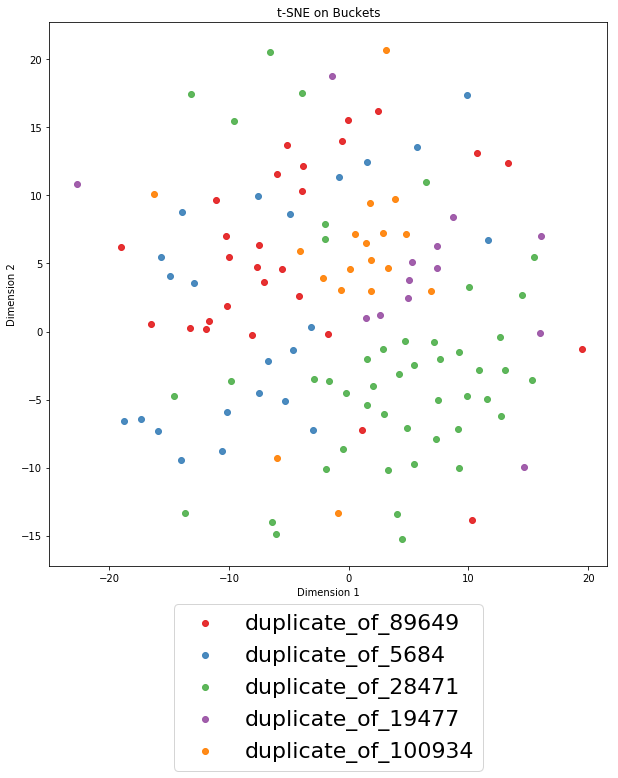

In [70]:
try:
    tsne_features_1epoch = create_features(test_features_1epoch)

    colors = plot_2d(categories_1epoch, tsne_features_1epoch, bucket_labels_1epoch, colors=colors, name='buckets_{}_{}1_epoch.png'.format(DOMAIN, METHOD))
except:
    pass

### 1000 epochs

In [71]:
test_features.shape, len(categories), len(bucket_labels)

((129, 1200), 129, 5)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 2.931000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.377548
[t-SNE] Error after 300 iterations: 0.473841


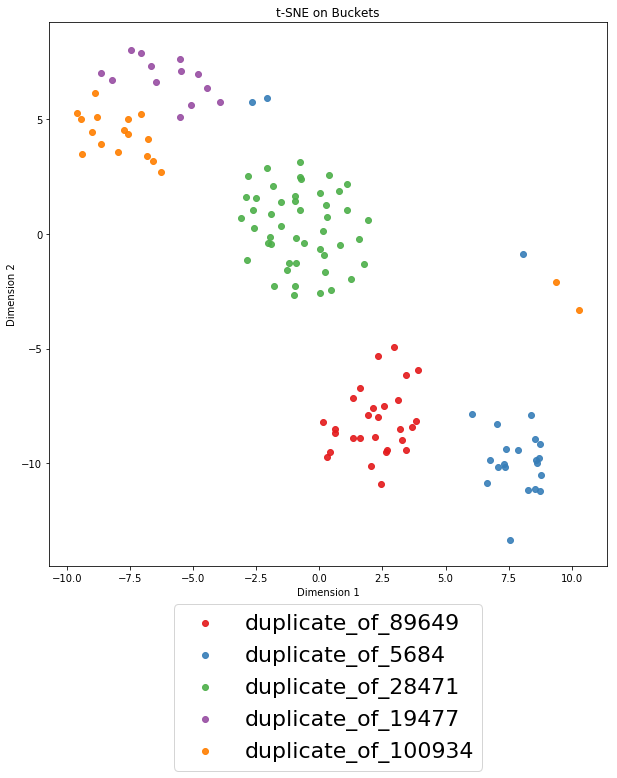

In [72]:
tsne_features = create_features(test_features)

_ = plot_2d(categories, tsne_features, bucket_labels, colors=colors, name='buckets_{}_{}1000_epoch.png'.format(DOMAIN, METHOD))

In [193]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
def display_outlier_contents(outlier_bug_ids):
    for bug in outlier_bug_ids:
        bug_outlier = df[df['bug_id'] == bug]

        printmd("#####################################")
        printmd("**Bug ID**: {}".format(bug_outlier['bug_id'].values[0]))
        printmd("**Bug status**: {}".format(bug_outlier['bug_status'].values[0]))
        printmd("**Component**: {}".format(bug_outlier['component'].values[0]))
        printmd("**Product**: {}".format(bug_outlier['product'].values[0]))
        printmd("**Resolution**: {}".format(bug_outlier['resolution'].values[0]))
        printmd("**Title**: {}".format(bug_outlier['short_desc'].values[0]))
        printmd("**Description**: {}".format(bug_outlier['description'].values[0]))

In [164]:
df = pd.read_csv(DATASET)

### Duplicate of 5684

In [240]:
bucket_outlier = 5684
outlier_x = tsne_features[np.where(np.asarray(categories) == 'duplicate_of_{}'.format(bucket_outlier)), 0]
outlier_y = tsne_features[np.where(np.asarray(categories) == 'duplicate_of_{}'.format(bucket_outlier)), 1]
outlier_x = outlier_x[0]
outlier_y = outlier_y[0]
index = np.where(outlier_y  > -5) # np.logical_and

In [241]:
outlier_x = outlier_x[np.where(outlier_x  > 7.5)]
outlier_y = outlier_y[np.where(outlier_y  > -5)]

In [242]:
outlier_bug_ids = np.asarray(bug_ids)[index]
outlier_bug_ids = np.insert(outlier_bug_ids, 0, bucket_outlier)
outlier_bug_ids

array([ 5684, 89346, 90157, 89163])

### Visualizing without outliers

In [243]:
buckets = retrieval.buckets
outliers_bucket = buckets[bucket_outlier]
outliers_bucket = outliers_bucket - set(outlier_bug_ids[1:])

display_outlier_contents(outliers_bucket)

#####################################

**Bug ID**: 5632

**Bug status**: CLOSED

**Component**: code

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Exit on first time entry

**Description**: A strange problem. When I first start Open Office it starts, displays the
default document and then immediately exits (n key presses or mouse clicks are
needed). I then start it again with the same mouse press and it starts ok. Any
ideas?

#####################################

**Bug ID**: 4808

**Bug status**: CLOSED

**Component**: code

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: OOo Writer starts and collapse

**Description**: Hi,

When I launch OOo Writer I get the usual blank page but, a few seconds after,
the application disappear.
(and nothing related to OO when i try a ps -eaf)

if I insert very rapidly a few carriage return or open a file OOo writer "stays"
on screen and seems to behave well

??

mainboard MSI KT3 Ultra + AMD ATHLON 1700+
Mandrake 8.2 (Xfree86 3.3.6 + Gnome 1.4)
OOo writer from the OO website

#####################################

**Bug ID**: 4236

**Bug status**: CLOSED

**Component**: code

**Product**: General

**Resolution**: DUPLICATE

**Title**: OpenOffice 641D is crashing spontaneously on AMD K6-2 systems

**Description**: I really have no idea if framework/code is the proper component/subcomponent
for this, but whenever I'm running 641D on an up2date Red Hat Linux 7.2 system
using an AMD K6-2/400 MHz system, OpenOffice is crashing reproducably. The
same program works as expected on Intel Pentium III/700Mhz and Intel Pentium
II/366MHz. The installation was done via './setup -net' first, followed by
the user specific install. The AMD systems have 96 MB RAM.

Could it be, that the binaries have been compiled with i686 optimization/code
generation on? This will not work on such AMD CPUs.

FWIW, 641C worked without any problems on all my systems.

#####################################

**Bug ID**: 6924

**Bug status**: CLOSED

**Component**: code

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: Open Office Writer and Calc seems to start and then close

**Description**: When starting Open Office Writer or Calc, the openoffice logo appears, the next
window frame is drawn, and then it abruptly closes.
To access writer or calc documents, I had to open Math or Impress and then click
on Open.
OpenOffice seems able to run, but fail to start Writer and/or Calc.
This strange behavior appeared abruptly 3 weeks after normal use.

OpenOffice is on an intel-i686 Red Hat Linux 7.3 machine.

#####################################

**Bug ID**: 4494

**Bug status**: CLOSED

**Component**: code

**Product**: gsl

**Resolution**: FIXED

**Title**: All Apps exit after start

**Description**: I installed V1.0.0 on my linux box (kernel 2.2.19/2.4.19-pre6).
The Installer says everything went OK, but I cant start any of
the Apps.

What happens is that a short time after start i see the main window
of the app started, but it will exit immediately. there is no core file of
any log entry indicating a problem, so i really dont know what to make out
of this, but it looks bad :-(

#####################################

**Bug ID**: 10768

**Bug status**: CLOSED

**Component**: code

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: program breaks on startup

**Description**: I reported some time ago -sorry I lost the reference- that when I run open
office for the third time after installation, it crashes mysteriously. 
Abit more information:
On Windows it runs fine.
On Linux, RH 7.3 it crashes.

I have since found that this only happens with the Gnome GUI. It works fine with
KDE. 
This means that the "Gnome integration" in the set up program is probably faulty.
However on the old (max 200MHz) machines that I work on, Gnome is significanly
faster.

I am keen to get this working properly, as I run a voluteer project in Swaziland
 to revive abandoned PCs for schools, and am dependant on open source sotware.

#####################################

**Bug ID**: 5522

**Bug status**: CLOSED

**Component**: code

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Open Office crashes

**Description**: I am running Red Hat 7.3 with Ximian updates, and a Ximian install of OpenOffice
1.0. I also have 
When I launch swriter from the command line, it flashes on the screen, then
disappears.
There is no core file, no errors to stderr (displayed on the xterm), no messages
to /var/log/message, nor can I find any log files in the OpenOffice directory.

I used to run the last OpenOffice beta, when I ran Red Hat v7.2, with no problems.

#####################################

**Bug ID**: 6291

**Bug status**: CLOSED

**Component**: code

**Product**: General

**Resolution**: DUPLICATE

**Title**: This environment var. SESSION_MANAGER crashes OpenOffice.org

**Description**: Hi! This only happens on a RedHat 7.3 Laptop class installation.
Really appreciate if any one can have a look. Thank you!

#####################################

**Bug ID**: 10451

**Bug status**: CLOSED

**Component**: code

**Product**: ui

**Resolution**: DUPLICATE

**Title**: soffice closes just after beeing opened du to a ~/.ICEauthority file.

**Description**: Hi,

[Context]

I had a working installation of OpenOffice, and installed new fonts as root.
From this moment, the application stopped to work for a particular user.

[Bug]

When I launch soffice or swriter, I get the welcome screen, and the application
opens as usual, but closes just before I should get the hand on it. (The window
closes, and the application quits.)

[Fix]

I managed to fix the problem by removing the ~/.ICEauthority file for this user.

From that moment, the application worked nicely. If I put the original file
back, the broken behavior comes back.

I played a little with strace and diff :

chezmoi:~> strace swriter > & /tmp/soffice-good.log
chezmoi:~> mv /tmp/carole.bak/.ICEauthority . # restoring the .ICEauthority file.
chezmoi:~> strace swriter > & /tmp/soffice.log
chezmoi:~> du -sh /tmp/soffice-good.log /tmp/soffice.log 
15M     /tmp/soffice-good.log
17M     /tmp/soffice.log
chezmoi:~> diff /tmp/soffice-good.log /tmp/soffice.log > /tmp/soffice.diff 
chezmoi:~> du -sh /tmp/soffice.diff 
31M     /tmp/soffice.diff


A portion of the diff file may be interesting (This is where the files begin to
differ really, and the reason why I suspected the .ICEauthority file.

2031,2039c2031,2081
< access("/home/carole/.ICEauthority", R_OK) = -1 ENOENT (No such file or directory)
< write(5, "\0\2\1\0\4\0\0\0\0\0\0\0\0\0\0\0\3\0MIT\0\0\0\3\0001.0"..., 40) = 40
< read(5, "\0\0\4\0\16\0\0\0", 8)         = 8
< read(5, "\2\1\0\0\2\0\0\0", 8)          = 8
< read(5, "a\0None of the authentication pro"..., 104) = 104
< close(5)                                = 0
< write(4, "\2\0\4\0002\0\0\0\0\10\0\0\0\0\10\0\1\30\v\0\1\0 \0032"..., 84) = 84
< read(4, "\20i\n\0002\0\0\0\1\0 \3\0\0\0\0\20\0\20\0\0\0\0\0\0\0"..., 32) = 32
< read(4, "\1\r\v\0\0\0\0\0\352\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"..., 32) = 32
---
> access("/home/carole/.ICEauthority", R_OK) = 0
> brk(0x808a000)                          = 0x808a000
> open("/home/carole/.ICEauthority", O_RDONLY) = 6
> fstat64(6, {st_mode=S_IFREG|0600, st_size=1445, ...}) = 0
> old_mmap(NULL, 4096, PROT_READ|PROT_WRITE, MAP_PRIVATE|MAP_ANONYMOUS, -1, 0) =
0x40d5c000
> read(6, "\0\3ICE\0\0\0!local/chezmoi:/tmp/.ICE"..., 4096) = 1445
> read(6, "", 4096)                       = 0
> close(6)                                = 0
> munmap(0x40d5c000, 4096)                = 0
> write(5, "\0\2\1\1\6\0\0\0\0\0\0\0\0\0\0\0\3\0MIT\0\0\0\3\0001.0"..., 56) = 56
> read(5, "\0\3\0@\1\0\0\0", 8)           = 8
> read(5, "\0\0\0\0\0\0\0\0", 8)          = 8
> access("/home/carole/.ICEauthority", R_OK) = 0
> open("/home/carole/.ICEauthority", O_RDONLY) = 6
> fstat64(6, {st_mode=S_IFREG|0600, st_size=1445, ...}) = 0
> old_mmap(NULL, 4096, PROT_READ|PROT_WRITE, MAP_PRIVATE|MAP_ANONYMOUS, -1, 0) =
0x40d5c000
> read(6, "\0\3ICE\0\0\0!local/chezmoi:/tmp/.ICE"..., 4096) = 1445
> close(6)                                = 0
> munmap(0x40d5c000, 4096)                = 0
> write(5, "\0\4\1\1\3\0\0\0\20\0\0\0\0\0\0\0\277?\\o\3,\201\0067\21"..., 32) = 32
> read(5, "\0\6\0@\2\0\0\0", 8)           = 8
> read(5, "\3\0MIT\0\0\0\3\0001.0\0\0\0", 16) = 16
> access("/home/carole/.ICEauthority", R_OK) = 0
> open("/home/carole/.ICEauthority", O_RDONLY) = 6
> fstat64(6, {st_mode=S_IFREG|0600, st_size=1445, ...}) = 0
> old_mmap(NULL, 4096, PROT_READ|PROT_WRITE, MAP_PRIVATE|MAP_ANONYMOUS, -1, 0) =
0x40d5c000
> read(6, "\0\3ICE\0\0\0!local/chezmoi:/tmp/.ICE"..., 4096) = 1445
> read(6, "", 4096)                       = 0
> close(6)                                = 0
> munmap(0x40d5c000, 4096)                = 0
> write(5, "\0\7\1\0\7\0\0\0\1\1\0\0\0\0\0\0\4\0XSMP\201\6\3\0MIT\335"..., 64) = 64
> read(5, "\0\3\0@\1\0\0\0", 8)           = 8
> read(5, "\0\0MIT\0\0\0", 8)             = 8
> access("/home/carole/.ICEauthority", R_OK) = 0
> open("/home/carole/.ICEauthority", O_RDONLY) = 6
> fstat64(6, {st_mode=S_IFREG|0600, st_size=1445, ...}) = 0
> old_mmap(NULL, 4096, PROT_READ|PROT_WRITE, MAP_PRIVATE|MAP_ANONYMOUS, -1, 0) =
0x40d5c000
> read(6, "\0\3ICE\0\0\0!local/chezmoi:/tmp/.ICE"..., 4096) = 1445
> close(6)                                = 0
> munmap(0x40d5c000, 4096)                = 0
> write(5, "\0\4\1\0\3\0\0\0\20\0\0\0\0\0\0\0\277?\\o\3,\201\0067\21"..., 32) = 32
> read(5, "\0\10\0\1\3\0\0\0", 8)         = 8
> read(5, "\7\0GnomeSM\0001.\7\0001.4.0.6\0\0\0", 24) = 24
> write(5, "\1\1\1\0\1\0\0\0\0\0\0\0\0\0\0\0", 16) = 16
> read(5, "\1\2\0\1\6\0\0\0", 8)          = 8
> read(5, "%\0\0\00011c0a80101000104169407000000"..., 48) = 48
> write(4, "\2\0\4\0002\0\0\0\0\10\0\0\0\0\10\0\1\30\v\0\1\0 \0032"..., 80) = 80
> read(4, "\20\272\n\0002\0\0\0\1\0 \3\0\0\0\0\20\0\20\0\0\0\0\0\0"..., 32) = 32
> read(4, "\1\325\v\0\0\0\0\0\361\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"..., 32) = 32
> write(4, "\22\0\20\0\1\0 \3\361\0\0\0\37\0\0\0\10\30\v\0%\0\0\000"..., 88) = 88
> read(4, "\1\325\r\0\0\0\0\0\352\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0\0"..., 32) = 32


The way the application quits when the bug occurs is given by the end of the
diff file :

267076,267079c311954,311957
< munmap(0x44ab9000, 274432)              = 0
< close(20)                               = 0
< munmap(0x44a32000, 274432)              = 0
< gettimeofday({1041694054, 87061}, NULL) = 0
---
> munmap(0x44a72000, 274432)              = 0
> gettimeofday({1041694140, 507661}, NULL) = 0
> gettimeofday({1041694140, 512536}, NULL) = 0
> gettimeofday({1041694140, 513746}, NULL) = 0
267083c311961
< close(9)                                = 0
---
> close(10)                               = 0
267087,267089c311965,311967
< close(6)                                = 0
< gettimeofday({1041694054, 100060}, NULL) = 0
< gettimeofday({1041694054, 100431}, NULL) = 0
---
> close(7)                                = 0
> gettimeofday({1041694140, 589984}, NULL) = 0
> gettimeofday({1041694140, 590352}, NULL) = 0
267093,267096c311971,311974
< close(5)                                = 0
< kill(16038, SIGRTMIN)                   = 0
< kill(16038, SIGRTMIN)                   = 0
< gettimeofday({1041694054, 102937}, NULL) = 0
---
> close(6)                                = 0
> kill(16082, SIGRTMIN)                   = 0
> kill(16082, SIGRTMIN)                   = 0
> gettimeofday({1041694140, 592837}, NULL) = 0
267106,267108c311984,311986
< kill(16039, SIGRTMIN)                   = 0
< shutdown(10, 2 /* send and receive */)  = 0
< close(10)                               = 0
---
> kill(16083, SIGRTMIN)                   = 0
> shutdown(11, 2 /* send and receive */)  = 0
> close(11)                               = 0
267128,267129c312006,312007
< close(16)                               = 0
< close(19)                               = 0
---
> close(17)                               = 0
> close(20)                               = 0

And the end of the log file of the buggy behavior :

082, SIGRTMIN)                   = 0
kill(16082, SIGRTMIN)                   = 0
gettimeofday({1041694140, 592837}, NULL) = 0
access("/tmp", W_OK)                    = 0
socket(PF_UNIX, SOCK_STREAM, 0)         = 5
fcntl64(5, F_GETFD)                     = 0
fcntl64(5, F_SETFD, FD_CLOEXEC)         = 0
access("/tmp/OSL_PIPE_1003_SingleOfficeIPC_-1247862714", F_OK) = 0
connect(5, {sin_family=AF_UNIX,
path="/tmp/OSL_PIPE_1003_SingleOfficeIPC_-1247862714"}, 110) = 0
send(5, "InternalIPC::TerminateThread", 28, 0) = 28
shutdown(5, 2 /* send and receive */)   = 0
close(5)                                = 0
kill(16083, SIGRTMIN)                   = 0
shutdown(11, 2 /* send and receive */)  = 0
close(11)                               = 0
unlink("/tmp/OSL_PIPE_1003_SingleOfficeIPC_-1247862714") = 0
rt_sigaction(SIGXFSZ, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGXCPU, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGVTALRM, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGIO, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGURG, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGWINCH, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGPWR, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGTERM, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGALRM, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGPIPE, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGSEGV, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGBUS, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGFPE, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGABRT, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGTRAP, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGQUIT, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGINT, {SIG_DFL}, NULL, 8) = 0
rt_sigaction(SIGHUP, {SIG_DFL}, NULL, 8) = 0
close(17)                               = 0
close(20)                               = 0
_exit(0)                                = ?



(I have a slow connection, so, posting the whole file is not possible)


Find the ~/.ICEauthority as attachement.

Another information of potential interest is that when the ~/.ICEauthority is
present, (so, when the bug is here), the log file is bigger (about 2Mb more)
each time. (For example, 19Mb the first time, then 22Mb, ...)

I noticed that the only file modified in the ~/OpenOffice.org directory is the
file ~/OpenOffice.org1.0/user/psprint/pspfontcache, which grows at each
execution. (with diff -r)

Hope this helps !

   Matthieu

#####################################

**Bug ID**: 12506

**Bug status**: CLOSED

**Component**: code

**Product**: ui

**Resolution**: DUPLICATE

**Title**: Problems loading OO due to full CPU load.

**Description**: At full CPU load (default priority level for running program), loading of OO
hangs and crashes. If renice +19 is issued OO loads as usual. 
Red Hat release 7.3 kernel 2.4.18

#####################################

**Bug ID**: 4827

**Bug status**: CLOSED

**Component**: ui

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Any OpenOffice component (Writer, Calc, etc...) closes as soon as it starts.

**Description**: I tried running OpenOffice through various methods: a GNOME shortcut, with or without the 
'private:factory/swriter', etc. and as well, the command-line.  I get no error messages, no 
segfaults, nothing.  About 2 seconds after the new writer document or calc spreadsheet 
appears, OpenOffice simply quits.  I experienced this on both RedHat 7.2 and 7.3 (the latter a 
fresh installation).  Did a ./setup -net straight from the tarball, deleted my old OpenOffice config 
files (like .sversionrc and .user60.rdb, as well as .openoffice -- custom local install path), then 
did a network install (via /usr/openoffice/program/soffice) to create the user-specific config files.

What frustrates me is sometimes it works, sometimes it doesn't.  I've tried various techniques to 
try and get this bugger reproducable (moving the mouse, leaving everything alone, switching to 
another window during load) and simply can't isolate the problem.

Also had this problem with the very last build before the 1.0.0 release.  It may be a dupe, but 
the search page looks more like a tax form than a query, so I wasn't able to find anything 
related to this already submitted.

Pentium II-350-ECC, Red Hat 7.3 (fresh install), 2 gig Maxtor IDE (Primary Master), 2.5 gig 
Quantum Fireball (Secondary Master), el cheap-o CD burner with SCSI emulation (Secondary 
Slave), 256MB RAM, 256MB swap (plenty of RAM free at the time), old Diamond Viper V550 
2xAGP 8MB TNT (tried it with and without nVidia's proprietary drivers), IMPS/2 mouse 
(Intellimouse explorer)...  Running GNOME 1.4 (default RH73 install).  Will watch the thread for 
more info req's.

#####################################

**Bug ID**: 7012

**Bug status**: CLOSED

**Component**: code

**Product**: porting

**Resolution**: DUPLICATE

**Title**: Crash upon startup

**Description**: After every reboot, when I run OpenOffice as user, the window frame is
displayed, but the application terminates after a few seconds, without filling
in the window (I can see everything thru it). When I run the program as root
first and then as user, everything is fine until the next reboot. I don't see
any directories or files with wrong permissions and I tried copying the system
libdb-3.2.so over the one that comes with OpenOffice, but  that doesn't change
anything.
I don't know how I can find out what might cause it to crash.

#####################################

**Bug ID**: 4709

**Bug status**: CLOSED

**Component**: code

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: When starting the first time in a session, Writer crashes seconds after starting.

**Description**: This happens EVERY TIME, when starting as a normal user. Debian Linux, GNOME
1.2, XFree 4.1. Starting also takes quite a while on my Celeron 466 MHz/384 MB.

When I restart OOo Writer directly after the crash it will run and work fine.

I have tried as root and it worked without crashing. But I didn't try that
often, because usually I don't do office work as root.

I have read Issue#: 4430, Issue#:  4470 and seen the remark about this problem
with the de_CH dictionary but this problem occurs, too, if de_CH is not present.

#####################################

**Bug ID**: 5926

**Bug status**: CLOSED

**Component**: code

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Open Office writer starts only after a second or third invocation

**Description**: When I start Open Office Writer on my home machine (Athlon 850/256 MB RAM) it
starts only after the second trial. After the first press of the appropriate
icon the Writer's window appears and gets closed immediately, before the cursor
starts to blink. On my office machine (Athlon 650/128MB RAM) it works similarly,
but usually it starts after the third trial. Additionally this efect depends on
the amount of time between the consecutive trials (the two trials on my home
machine, or three trials on my office machine must be performed very quickly one
after another, otherwise the Open Office Writer does not start at all).
 It seems that it may be a timeout problem when initializing different threads
of the application?

#####################################

**Bug ID**: 5799

**Bug status**: CLOSED

**Component**: ui

**Product**: ui

**Resolution**: DUPLICATE

**Title**: openoffice.org fails to startup on first try on redhat 7.3 linux

**Description**: Every time I try to start any OOo program on a fresh booted system (pentium 233 MMX, 96 meg ram), It comes up all the way and immediatly 
shuts down without any errors. If I retry it usually succeeds (sometimes takes a couple of attempts). Once its up and running, It appears to be 
fine. This does not happen on a faster redhat 7.3 system (866 P3 w/512 megs ram), I have duplicated this on 2 different systems with the only 
common thread is the Redhat 7.3 and Pentium 233 MMX.

#####################################

**Bug ID**: 4200

**Bug status**: CLOSED

**Component**: api

**Product**: App Dev

**Resolution**: DUPLICATE

**Title**: Openoffice crashes after opening in Ximian

**Description**: Hi, I have OpenOffice installed on a Mandrake 8.1 Linux PC.  It worked fine for 
a few days, but since I've installed the Ximian Gnome desktop, it will open, 
then crash as soon as you click any part of the screen or try to insert any 
text.  Do you know of any issues with Ximian or Gnome?  I'm also querying their 
web sites.

Thanks,

-j

#####################################

**Bug ID**: 6633

**Bug status**: CLOSED

**Component**: ui

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: SESSION_MANAGER environment variable

**Description**: I use Gnome on my machine.
Whenever I am trying to run soffice while the environment variable 
SESSION_MANAGER has some particular value soffice exits before the loading is
completed.
Nevertheless, if I run simpress first and only then swriter, it goes smoothly.

#####################################

**Bug ID**: 5099

**Bug status**: CLOSED

**Component**: code

**Product**: ui

**Resolution**: DUPLICATE

**Title**: openoffice crashes at open

**Description**: I have noticed the problem on several installs of openoffice. Environment details:
- verified on Linux 2.2.19 and 2.4.18
- Gnome desktop
- verified on PCs PIII 700 256mb RAM, PII 500 64mb RAM, PIII 500 512mb RAM
- verified in 641d and apparently 1.0.0

Problem:
- When OOo started from a Gnome menu or panel, application starts up, shows the
component selected (swriter/scalc...) pauses for a second and then disappears -
crashes. Since started from menu no error is displayed.
- When restarted immediately after this crash the component will in 80% cases
stay open and allow to be used. However, if there is a longer wait (5-10s)
between the first crash and the second attempt to open from a menu, it will
crash again.
- If Mozilla is open OOo will not stay open no matter what or how many attempts
are made to open it.
- However, when the component is started from a terminal typing exactly the same
command as used in the menu it will start and stay open without problems,
regardless of whether Mozilla is open or not.
- Also, if the components are started from Nautilus with file association they
will present the same problems as above.
- But if the components are started from OpenOffice QuickStarter applet these
problems will not show up.

This has been verified on several platform and kernel combinations with the same
results. I have personally verified it on 641d, however, have heard several user
reports that 1.0.0 has the same problem.

Thanks... and keep up the good work!

#####################################

**Bug ID**: 7917

**Bug status**: CLOSED

**Component**: ui

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: Root succeeds, user fails

**Description**: OpenOffice 1.0.1 (downloaded tarball), RedHat 7.3 Intel workstation install,
nothing special modified.

I successfully did a network install as root, then successfully did workstation
installs as both root and a regular user. root is able to run soffice
successfully; the normal user is not. When the normal user runs soffice the logo
appears, disk grinds for a while, logo disappears, border of a window is drawn
but never filled in, then the window disappears and the message "Aborted" is
printed on the terminal window.

There are a few twists to this story: The regular user is initially able to run
the swriter program successfully immediately after the workstation install;
however, after he logs out of X and logs in again he is no longer able to run
swriter; it fails with the "Aborted" message just like soffice. The regular user
is never able to run the soffice program successfully.

I found 2 tips in the newsgroups: 1) Verify all fonts are valid; 2) check for
write permission on all OpenOffice files in the regular user directory. Red Hat
7.3 uses xfs; initially it was complaining about some erroneous font paths, but
I removed them with chkfontpath and now xfs emits no errors. Also I did chmod -R
ug+rw OpenOffice.org1.0.1/* in the regular user directory, which should
guarantee write access to all OpenOffice files (I also did this for the
.sversionrc file).  Neither of these suggestions helped anything.

I still have the problem of the "Aborted" message when running soffice (and
swriter) as the regular user. What is going on? Help!

#####################################

**Bug ID**: 5684

**Bug status**: CLOSED

**Component**: ui

**Product**: ui

**Resolution**: DUPLICATE

**Title**: OpenOffice tries to close on startup

**Description**: Howdy;

I've got a peculiar issue with both OpenOffice and StarOffice (1.0 and 6.0
respectively).  This makes me think that it's an environment issue.

Initially, I thought this was logo related (reference
http://www.openoffice.org/servlets/ReadMsg?msgId=329389&listName=users) but it
turns out I'd been hitting the crack pipe a bit too hard (it's not logo related,
it was a flaw in my methodology).

What appears to be the case is that *Office is trying to start up, and then it
tries to close (presumably with some sort of File, Close).  This is evidenced by
it starting whatever application you want, and then immediately closing it.

This is irrespective of whether it's a new or previous document.

The way to hack around this issue is to be very quick with the key strokes.  On
startup, if you can get in there and enter some data into the application, it
will ask you if you want to Save/Discard/Cancel.  If you say Cancel, then it
continues on happily, and you can open/save/whatever to your heart's content.

I now believe I know why this is occuring; it appears to be a conflict in
xscreensaver.  I'm running:

$ dpkg --list xscreensaver\*
Desired=Unknown/Install/Remove/Purge/Hold
| Status=Not/Installed/Config-files/Unpacked/Failed-config/Half-installed
|/ Err?=(none)/Hold/Reinst-required/X=both-problems (Status,Err: uppercase=bad)
||/ Name           Version        Description
+++-==============-==============-============================================
ii  xscreensaver   3.34-3         Automatic screensaver for X
ii  xscreensaver-g 3.34-3         GL(Mesa) screenhacks for xscreensaver
ii  xscreensaver-g 3.34-3         GNOME binaries for xscreensaver

If I kill the daemon, then I can start *Office just fine.

I am going to file a bug on xscreensaver for this as well, and reference this
project issue.  I've got a workaround, so it's hardly major or urgent, just damn
annoying :)

Cheers

Richard

#####################################

**Bug ID**: 4470

**Bug status**: CLOSED

**Component**: code

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: crash using gnome 1.4

**Description**: When I start OO as a normal user, there always appears the import address book
dialog and the OO-mainwindow crashes in background. When I then press any button
in the dialog, it also crashes with an "unrecoverable error" message and soffice
returns to the console-prompt.

As root user, OO seems to act as normal.

#####################################

**Bug ID**: 7416

**Bug status**: CLOSED

**Component**: ui

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: soffice exits without any diagnostic message

**Description**: A while ago I installed openoffice.org 1.0.1. (Multiuser installation). The
post-installation setup had some anomalies (reported separately) but I was
subsequently able to use openoffice.org's spreadsheet.
But today, I type ./soffice from the OpenOffice.org1.0.1 directory, and the
OpenOffice splash bitmap appears, but then it just quits without trace. No
diagnostics, nothing - at least not in the xterm session I started it from.

My installation is on Debain Linux Woody (the official release installed from CDs).

This problem obviously makes OpenOffice.org unusable.

#####################################

**Bug ID**: 5945

**Bug status**: CLOSED

**Component**: code

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Open Office crashes silently on startup

**Description**: when starting openoffice, it will crash silently if left alone for a couple of
seconds. if Ctl-O is pressed (open file) it stays open without crashing.

the output when run in a terminal is...

# /usr/local/openoffice1.0$ ./soffice 
sh: /usr/sbin/lpc: No such file or directory
sh: lpc: command not found
sh: lpstat: command not found


.. and then the program crashes (i dont have a printer so i dont have lpd
installed). If I restart it again, it sometimes stays up. On the third restart &
subsequent restarts, it stays up & doesnt crash.

Im using Debian Woody on a toshiba laptop x86 PIII, 128MB ram X, 4.1.0.1
OpenOffice 1.0.0

### Outliers

In [244]:
display_outlier_contents(outlier_bug_ids)

#####################################

**Bug ID**: 5684

**Bug status**: CLOSED

**Component**: ui

**Product**: ui

**Resolution**: DUPLICATE

**Title**: OpenOffice tries to close on startup

**Description**: Howdy;

I've got a peculiar issue with both OpenOffice and StarOffice (1.0 and 6.0
respectively).  This makes me think that it's an environment issue.

Initially, I thought this was logo related (reference
http://www.openoffice.org/servlets/ReadMsg?msgId=329389&listName=users) but it
turns out I'd been hitting the crack pipe a bit too hard (it's not logo related,
it was a flaw in my methodology).

What appears to be the case is that *Office is trying to start up, and then it
tries to close (presumably with some sort of File, Close).  This is evidenced by
it starting whatever application you want, and then immediately closing it.

This is irrespective of whether it's a new or previous document.

The way to hack around this issue is to be very quick with the key strokes.  On
startup, if you can get in there and enter some data into the application, it
will ask you if you want to Save/Discard/Cancel.  If you say Cancel, then it
continues on happily, and you can open/save/whatever to your heart's content.

I now believe I know why this is occuring; it appears to be a conflict in
xscreensaver.  I'm running:

$ dpkg --list xscreensaver\*
Desired=Unknown/Install/Remove/Purge/Hold
| Status=Not/Installed/Config-files/Unpacked/Failed-config/Half-installed
|/ Err?=(none)/Hold/Reinst-required/X=both-problems (Status,Err: uppercase=bad)
||/ Name           Version        Description
+++-==============-==============-============================================
ii  xscreensaver   3.34-3         Automatic screensaver for X
ii  xscreensaver-g 3.34-3         GL(Mesa) screenhacks for xscreensaver
ii  xscreensaver-g 3.34-3         GNOME binaries for xscreensaver

If I kill the daemon, then I can start *Office just fine.

I am going to file a bug on xscreensaver for this as well, and reference this
project issue.  I've got a workaround, so it's hardly major or urgent, just damn
annoying :)

Cheers

Richard

#####################################

**Bug ID**: 89346

**Bug status**: CLOSED

**Component**: code

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: odt file type not associated

**Description**: When installing 3.0 beta for Windows, the file type .odt is not associated with
open office.  So, when double clicking on these files, one gets the standard
Windows dialog asking what application to run.

#####################################

**Bug ID**: 90157

**Bug status**: CLOSED

**Component**: ui

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: Not assigned extensions

**Description**: Installation program of OpenOffice 3.0 Beta does not assign extensions. I must
do it manually, otherwise it is not possible to open documents by double-click.

#####################################

**Bug ID**: 89163

**Bug status**: CLOSED

**Component**: code

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: file-extensions and -types are not registered in Windows upon insatllation

**Description**: On my (german) Windows XP SP3 there are no file-types registered for
OO-Documents. I did not recognize that Behaviour with older developer versions
of OO3

### Duplicate of 100934

In [222]:
bucket_outlier = 100934
outlier_x = tsne_features[np.where(np.asarray(categories) == 'duplicate_of_{}'.format(bucket_outlier)), 0]
outlier_y = tsne_features[np.where(np.asarray(categories) == 'duplicate_of_{}'.format(bucket_outlier)), 1]
index = np.where(np.asarray(outlier_y[0])  < 0)

In [143]:
outlier_x = outlier_x[0][np.where(np.asarray(outlier_x[0])  > 7.5)]
outlier_y = outlier_y[0][np.where(np.asarray(outlier_y[0])  < 0)]

In [159]:
outlier_bug_ids = np.asarray(bug_ids)[index]
outlier_bug_ids = np.insert(outlier_bug_ids, 0, bucket_outlier)
outlier_bug_ids

array([100934,  91415,  90056])

### Visualizing group without outliers

In [194]:
buckets = retrieval.buckets
outliers_bucket = buckets[bucket_outlier]
outliers_bucket = outliers_bucket - set(outlier_bug_ids[1:])

display_outlier_contents(outliers_bucket)

#####################################

**Bug ID**: 99200

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Errors in saved DOC files

**Description**: OOO 3.0.1 Italian on Windows XP SP3.

1) I open a DOC file. Everything is fine.
2) I save the file without any change suing the same DOC file but different name.
3) I open the new DOC file. Contents is chaotic.

On these files, I was working with OOO 3.0 without problems.

#####################################

**Bug ID**: 100161

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: File saved as M.Word 97/2000/XP (.doc) corrupted

**Description**: The file came to me as a one page .doc form (NOT .dot) and included 3 tables. 
After completing I saved it back as Word 97/200/XP.  The resulting file does not
open in Word 2000 and when opened in OO Writer the second and third tables are
missing and replaced by a lot of space forcing the final text on to the next page.

I have the file available for analysis if desired.

#####################################

**Bug ID**: 100545

**Bug status**: CLOSED

**Component**: formatting

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: WW8: certain cell border in complex table is missing after import

**Description**: When I download the NIH biosketchsample.doc from the NIH website
(grants.nih.gov/grants/funding/phs398/biosketchsample.doc) and then try to open
it in openoffice 3.0.1 (OOO300m15) build 9379, the table at the top of page 1
does not display properly.

It may have something to do with copying the file, since it sometimes seems to
open properly the first time but once I have tried to save it, even if no
changes were made, it does  not display the table at the top of page 1.

I am running openoffice on a ubuntu intrepid linux system on a PC.

Thanks.
E.J. Neafsey

#####################################

**Bug ID**: 99334

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: WW8: Table column width wrong after save as .doc file...

**Description**: Summary:

Saving a table with alignment "Manual" or "From Left" to Microsoft Word 
97/200/XP format seems to save the columns widths wrong.

Details:

I created a new Text document via OOo 3.0.1.
I inserted a table with 2 rows and 2 columns, and entered some text into both
columns of the first row.
I changed the table alignment from Automatic to Manual by dragging the left
edge to the right a bit, the right edge to the left a bit, and dragging the 
middle divider to the exact position I wanted it.
I then saved the file in Microsoft Word 97/200/XP format and exited OOo.

When I re-opened the file in OOo 3.0.1, the column widths had changed.
When I look at the Table properties, I see that the alignment is now 
"From Left", not "Manual".

The problem definitely occurs during the save, not during the re-open. Opening
the file in Microsoft Word 2003 instead of OOo shows that the column width is
also wrong there.

When I re-open the file in OOo 3.0.1 and drag the columns to the desired width
again, and then check the Table properties, I see that the alignment is still
"From Left", not "Manual". Saving in Microsoft Word 97/200/XP format and
re-loading shows the column widths once again changed from what I specified.

Doing the same experiment with regular ODT format instead of MS Office format
works fine. The column widths are preserved and the alignment remains "Manual".

My small test file is at:
     http://bristle.com/OpenOffice/Bugs/3.0.1/OOo301ColumnWidthBug.doc

BTW, keep up the good work! I am new to OOo and hoping to entirely abandon
MS Office. I'll be moving from Windows XP to Mac OS X Leopard shortly, and
hope to not buy MS Office ever again.

--Fred
---------------------------------------------------------------------
Fred Stluka -- mailto:fred@bristle.com -- http://bristle.com/~fred/
Bristle Software, Inc -- http://bristle.com -- Glad to be of service!
---------------------------------------------------------------------

#####################################

**Bug ID**: 100934

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: tables lost when saving in word 97 format

**Description**: when saving the attached document as a word 97 file (.doc) the tables (arrays)
are lost. This also happens with other documents including formatted tables
(letterheads aso). This bug is a regression, since it was not present in version
3.0.0 (to which I returned)

#####################################

**Bug ID**: 99719

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Word97 .doc export deletes tables from text

**Description**: Saving a document with tables as Word97 .doc deletes the table from the text. This happened while 
editing a Word file received from a customer and resulted in data loss.

Importing and displaying the tables works fine, saving as .odt also preserves the tables, but saving as .doc 
deletes them (there is only white space left where the tables were previously located).

To reproduce, open the attached file "tableloss.odt" (whose text has been anonymised as it contained 
sensitive information) and save as Word97 .doc and reopen in Word or OOo: All your tables and their 
content are lost! (Opening the .odt with NeoOffice 2.2.5 and saving as .doc behaves correctly, BTW)

#####################################

**Bug ID**: 99024

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: FIXED

**Title**: WW8: table with center alignment disappears when exported

**Description**: Hi

My configuration : OOo 3.0.1 FR under Ubuntu 8.04.
Step to reproduce :

1/ open new text document ;
2/ insert a table, for example 2 rows and 3 columns ;
3/ menu Table > Table properties > Tab Table
4/ choose Alignment Center and click Ok ;
5/ save the file as odt
6/ menu File > Save as and choose file format MS-Word 97/2000/XP (.doc)
7/ close the file .doc
8/ reopen the doc file with OOo 3.0.1 => the table has disappeared 

In fact the table exists (you can see it from navigator) but has wrong
characteristics : 
- alignment is from left
- width is 34 cm
- spacing right is -136,53 cm
- there is only one column

If I open the doc file with Ms-Word Viever 2003 the table is not visible.

Several users confirmed this issue on other OS (XP, MacOS, Linux)

Same steps do crash DEV300_m40 when exporting as doc file but it's known issue
(http://www.openoffice.org/issues/show_bug.cgi?id=98465).

Regards
JBF

#####################################

**Bug ID**: 100435

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: odt table output as doc table disappears

**Description**: From the Ubuntu bug report:
"
Creating a Table and saving the file as odt works fine. When I then save it as a
doc file, the table is always corrupted. Usually column width changes.
--
I tried this process again and I think I have narrowed it down. I made a simple
table in odt and successively edited/saved/closed it as a doc. Each time adding
colors, bullets, rows etc. 7 times in all. All was okay. On the 8th time I
centered the table (Using Table Properties) - when I re-opened , it had
disappear altogether. See attached doc. This may help narrow down the issue.
--
I've messed about a bit with this. Any table that has been created and
then moved (using Table properties) and then saved in OO as a doc;
closed it and open it, the table has disappeared. Pretty serious bug I
would think.
"

input file:
http://launchpadlibrarian.net/22933018/Table%20Test.odt

output file:
http://launchpadlibrarian.net/22932990/Table%20Test.doc

simple output file:
http://launchpadlibrarian.net/22933353/simple%20table.doc

Verified on official OOo 3.0.1

#####################################

**Bug ID**: 101205

**Bug status**: CLOSED

**Component**: formatting

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: WW8: bug formatting in MS Word format

**Description**: When using MS Word file storage with a array 2 columns at least half size large
of the page. When centering it, saving the file in ".doc" and closing
OpenOffice, afterwaerd reoppening it, the array formatting is broken.

#####################################

**Bug ID**: 104021

**Bug status**: CLOSED

**Component**: viewing

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: OpenOffice 2.4 can't read tables in doc format made by OOo 3+

**Description**: You can see the borders of the table, so it's there. But there is no text inside it.

It made me upgrade the whole office to 3.1, but woopsie, there comes the bug
with NO TABLES being shown. And there is still no upgrade for it, so I
downgraded to OOo 2.4, but the people that run OOo 3+ keep spitting out bad
tables w/o text.

Soo. What to do.

#####################################

**Bug ID**: 99289

**Bug status**: CLOSED

**Component**: formatting

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Wrong table formating in Word 97/2000/XP file format

**Description**: I attached document which has been created in MS Word 2003. There are two pages
and a table which is located on the second one. When I open this document in Ooo
Writer, change any text and save it with DOC extension (i.e. in Word 2003
format), the table change formating. It is moved to the right border of the page
and the column with is changed. That's why the table does not displays.

#####################################

**Bug ID**: 106395

**Bug status**: CLOSED

**Component**: viewing

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: WW8: Table missing

**Description**: I've been working with my resume which has a table in it for some time and now a
recent update to OOo has made the table disappear. I'm certain the table was in
there because there's a giant blank place where it used to be. I also checked an
old version that I sent to a potential employer and the table is missing in that
version as well. The document was created in Word 2003, then updated in OOo
Writer in which I exported to doc format. 

I have a backup of the table but I would like to know if this is a bug that I
should be concerned about.

Thank you.

#####################################

**Bug ID**: 101211

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: WW8: compatibility problem Ms_word_2k Ooo

**Description**: hy all,
with version 3.x have introduced a lot of new things, but some errors too, like 
mine. Using normaly Ms Office and Openoffice too, i have made a doc, as it is 
quite a problem to make it with openoffice, it is named (bla bla 
bla_word_2000.doc => attachement). i can open it with both programms. When i 
open it with openoffice and save it in odt, it works again. when i open it in 
openoffice and make some changes and save it in .doc again then i can't opening 
in word_2k again. and reopening in openoffice a lot of things are lost. I 
remember that in version 2.x it works, but now it don't works.
take a look and if somebody has time please solve it.
greetings

#####################################

**Bug ID**: 99613

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Messed up document when saved in MS Word format

**Description**: Mandriva 2008.1, used Czech official RPMs (for both 2.4.1 and 3.0.1).

I'd like to point this out as possible regression, as in OO 2.4.1 everything
works fine.

Might be related to issue 99451.

Demonstration:
(well, at least on my PC :)

1a) Let's open an original document with OO 3.0.1 (DOC, saved by OO 2.4.1).
1b) Let's open an original document with OO 3.0.1 (ODF, saved by OO 2.4.1).
2)  Everything looks OK.
3)  Save it as DOC (MS Word 97/2000).
4)  Now open saved files in OO 3.0.1.
5a) Document is messed up (most tables gone, a lot more pages...).
5b) OO crashes.
6)  Now open these files in OO 2.4.1.
7)  Both are messed up, no crash.

#####################################

**Bug ID**: 99625

**Bug status**: CLOSED

**Component**: formatting

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Table resize itself if the table offset from the page margin in .doc format when reopen

**Description**: if save in .doc format, if the table is not in-line with the page margin, then
at next re-open the doc file, the table will resize itself.

#####################################

**Bug ID**: 99757

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: .doc formatting corrupted on save

**Description**: See attached .doc file. Simply opening and saving this 3 page file results in a
file that is 6 pages long for no apparent reason.

I also did the following test:
- open original .doc file. (formatting OK)
- save-as .odt
- close file
- open .odt version. (formatting OK)
- save-as .doc format
- close file
- open .doc version  (formatting broken)

So I am quite confident the .doc export is wrecking the formatting.

#####################################

**Bug ID**: 100342

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: when saving as ".doc" all tables with their contentys are lost

**Description**: The issue emerged after I worked several hours on a .doc document originally
written with microsoft office. After saving the document I observed that I've
lost all the tables with my work.
Trying to reproduce the bug I've found that If I save from .doc to .odt I can
preserve the tables, but again trying to save from .odt to .doc I lost all of them.
I attache a .odt document with some tables which will get lost if you try to
save it as .doc. 
I've also observed that if you put the alignment of tables to automatic (in the
.odt) strangely the problem doesn't appear.

#####################################

**Bug ID**: 100091

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: Saving Microsoft Word document loses table

**Description**: NB this applies to version 3.0.2 but I couldn't see that option in the version
field. I have reverted back to 3.0.1 and have not been able to reproduce so the
problem appears to have been introduced with 3.0.2.

Steps to reproduce:

1) Open my sample Microsoft Word document in Writer.
2) Verify table appears.
3) Click File->Save As-> MS Word 97 Format, perhaps to your desktop.
4) Open newly saved file with Writer.

Expected result:

* Newly displayed file in step 4 shows the table in step 2.

Actual result:

* Newly displayed file does not show table from step 2.

### Outliers

In [195]:
display_outlier_contents(outlier_bug_ids)

#####################################

**Bug ID**: 100934

**Bug status**: CLOSED

**Component**: save-export

**Product**: Writer

**Resolution**: DUPLICATE

**Title**: tables lost when saving in word 97 format

**Description**: when saving the attached document as a word 97 file (.doc) the tables (arrays)
are lost. This also happens with other documents including formatted tables
(letterheads aso). This bug is a regression, since it was not present in version
3.0.0 (to which I returned)

#####################################

**Bug ID**: 91415

**Bug status**: CLOSED

**Component**: ui

**Product**: Installation

**Resolution**: DUPLICATE

**Title**: [Trad Chinese installer] Cannot assign .doc, .xls and .ppt filename

**Description**: In the Trad Chinese 3.0 beta installer,
even if the boxes about associating MS office filename extensions were ticked,
these extensions did not assigned to Ooo automatically.

I'm using Windows XP SP2, running CPU "Intel(R) 2140 @ 1.6 GHz"

#####################################

**Bug ID**: 90056

**Bug status**: CLOSED

**Component**: ui

**Product**: General

**Resolution**: DUPLICATE

**Title**: File-associations missing/corrupted after installation

**Description**: Platform: MS Windows XP professional (SP3)
Language: German
Package: OOo_3.0.0beta_20080429_Win32Intel_install_wJRE_de.exe

After installing OOo 3 Beta no files are assigned to OOo even though it is
chosen during installation to assign MS-documents to OOo.

Having OOo 2.x installed, associations to MS-documents are re-assigned to
MS-standard when choosing assignment to OOo 3 during installation. OOo-documents
are still assigned to the previously installed OOo version.

## Topic latent space

In [ ]:
if('deepQL_topics' in METHOD):
    topic_size = K.int_shape(model_1_epoch.get_layer('topics_in').output)[1]
    print("Total of topics ", topic_size)

In [ ]:
bugs = experiment.baseline.get_bug_set()
print("Total of bugs", len(bugs))

#### Group bugs by topics

In [ ]:
if('deepQL_topics' in METHOD):
    bugs_by_topic = dict( (t, []) for t in range(topic_size) )
    for bug_id in bugs:
        bug = bugs[bug_id]
        bugs_by_topic[bug['topic']].append(bug_id)
    print("Topics {}".format(len(bugs_by_topic)))

#### Selecting random bugs for each topic

In [ ]:
bugs_topics_selected = []
if('deepQL_topics' in METHOD):
    number_of_bugs_select = 50
    for t in range(topic_size):
        sample = np.random.choice(bugs_by_topic[t], number_of_bugs_select)
        sample_labeled = [ (bug_id, bugs[bug_id]['topic']) for bug_id in sample ]
        bugs_topics_selected += sample_labeled

In [ ]:
def create_tsne_vector_bert_topics(model, method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    topic_labels = set()

    for row  in bugs_topics_selected:
        bug_id, topic = row
        # bucket and dups
        if bug_id in retrieval.buckets:
            label = 'topic_{}'.format(topic)
            categories.append(label)
            topic_labels.add(topic)

        bug = baseline.bug_set[bug_id]
        
        title_data.append(bug['title_token'])    
        title_data_seg.append( [int(v > 0) for v in bug['title_token']] )
        desc_data.append(bug['description_token'])
        desc_data_seg.append( [int(v > 0) for v in bug['description_token']] )
        info_data.append(experiment.retrieval.get_info(bug))
        if('topics' in bug):
            topic_data.append(bug['topics'])
    topic_labels = [ "topic_{}".format(l) for l in list(topic_labels) ]
    
    test_features = model.predict([ np.array(title_data), np.array(title_data_seg), 
                                   np.array(desc_data), np.array(desc_data_seg), 
                                   np.array(info_data), np.array(topic_data) ])
    
    return topic_labels, test_features, categories

In [ ]:
def create_tsne_vector_bert(model, feat='title', method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    topic_labels = set()
    bug_ids = []

    for row  in bugs_topics_selected:
        bug_id, topic = row
        # bucket and dups
        if bug_id in retrieval.buckets:
            label = 'topic_{}'.format(topic)
            categories.append(label)
            topic_labels.add(topic)

        bug = baseline.bug_set[bug_id]
        
        title_data.append(bug['title_token'])    
        title_data_seg.append( [int(v > 0) for v in bug['title_token']] )
        desc_data.append(bug['description_token'])
        desc_data_seg.append( [int(v > 0) for v in bug['description_token']] )
        
    topic_labels = [ "topic_{}".format(l) for l in list(topic_labels) ]
    
    if(feat == 'title'):
        test_features = model.predict([ np.array(title_data), np.array(title_data_seg) ])
    else:
        test_features = model.predict([ np.array(desc_data), np.array(desc_data_seg) ])
    
    return topic_labels, test_features, categories

In [ ]:
def create_tsne_vector_topics(model, method='bert'):
    test_features = []
    title_data, title_data_seg, desc_data, desc_data_seg, info_data, topic_data = [], [], [], [], [], []
    categories = []
    topic_labels = set()

    for row  in bugs_topics_selected:
        bug_id, topic = row
        # bucket and dups
        if bug_id in retrieval.buckets:
            label = 'topic_{}'.format(topic)
            categories.append(label)
            topic_labels.add(topic)

        bug = baseline.bug_set[bug_id]
        
        if('topics' in bug):
            topic_data.append(bug['topics'])
    topic_labels = [ "topic_{}".format(l) for l in list(topic_labels) ]
    

    test_features = model.predict([ topic_data ])
    
    return topic_labels, test_features, categories

In [ ]:
if('deepQL_topics' in METHOD):
    colors_topics = sns.color_palette("hls", n_colors=topic_size) 

### Topics (LDA)

In [ ]:
model.summary()

In [ ]:
if('deepQL_topics' in METHOD):
    topic_model = model.get_layer('FeatureTopicMlpGenerationModel')
    topic_labels, test_features, categories = create_tsne_vector_topics(topic_model, method=EMBEDDING_METHOD)

    tsne_features = create_features(test_features)

In [ ]:
if('deepQL_topics' in METHOD):
    colors = plot_2d(categories, tsne_features, topic_labels, \
                     colors=colors_topics, name='topics_{}_{}_1000_epoch.png'.format(DOMAIN, METHOD))

### Topics for 1000 epochs BERT in Title

In [ ]:
if('deepQL_topics' in METHOD):
    bert_t_model = model.get_layer('FeatureBERTGenerationModelTitle')
    topic_labels, test_features, categories = create_tsne_vector_bert(bert_t_model, feat='title', method=EMBEDDING_METHOD)

    tsne_features = create_features(test_features)

In [ ]:
if('deepQL_topics' in METHOD):
    colors = plot_2d(categories, tsne_features, topic_labels, \
deepQL_topics_colors=colors_topics, name='bert_title_{}_{}_1000_epoch.png'.format(DOMAIN, METHOD))

### Topics for 1000 epochs BERT in Desc

In [ ]:
if('deepQL_topics' in METHOD):
    bert_d_model = model.get_layer('FeatureBERTGenerationModelDescription')
    topic_labels, test_features, categories = create_tsne_vector_bert(bert_d_model, feat='desc', method=EMBEDDING_METHOD)

    tsne_features = create_features(test_features)

In [ ]:
if('deepQL_topics' in METHOD):
    colors = plot_2d(categories, tsne_features, topic_labels, \
                     colors=colors_topics, name='bert_desc_{}_{}_1000_epoch.png'.format(DOMAIN, METHOD))